In [18]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import mediapipe as mp
import torch
from torchvision import transforms
from facenet_pytorch import InceptionResnetV1
from sklearn.decomposition import PCA

In [ ]:
# Initialize MediaPipe Face Detection
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

# Initialize FaceNet model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")
facenet = InceptionResnetV1(pretrained='vggface2').eval()
facenet = facenet.to(device)

def whitens(img):
    mean = img.mean()
    std = img.std()
    std_adj = std.clamp(min=1.0 / (float(img.numel()) ** 0.5))
    y = (img - mean) / std_adj
    return y

def detect_and_extract_face(image_path, face_detection, min_detection_confidence=0.5):
    # Read image and convert to RGB
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not read image: {image_path}")
        return None, None
    
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape
    
    # Process the image with MediaPipe
    results = face_detection.process(image_rgb)
    
    if not results.detections:
        print(f"No faces detected in {image_path}")
        return None, None
    
    # Extract faces and bounding boxes
    extracted_faces = []
    bounding_boxes = []
    
    # Prepare transformation for FaceNet
    transform = transforms.Compose([
        transforms.Resize((160, 160)),  # FaceNet expects 160x160 images
        transforms.ToTensor()
    ])
    
    for detection in results.detections:
        # Get bounding box coordinates
        bbox = detection.location_data.relative_bounding_box
        xmin = int(bbox.xmin * w)
        ymin = int(bbox.ymin * h)
        width = int(bbox.width * w)
        height = int(bbox.height * h)
        
        # Ensure valid coordinates (sometimes MediaPipe returns negative values)
        xmin = max(0, xmin)
        ymin = max(0, ymin)
        width = min(w - xmin, width)
        height = min(h - ymin, height)
        
        # Extract face
        face_img = image_rgb[ymin:ymin+height, xmin:xmin+width]
        if face_img.size == 0:
            continue
            
        # Convert to PIL Image, apply transformations
        face_pil = Image.fromarray(face_img)
        face_tensor = transform(face_pil).unsqueeze(0).to(device)
        
        extracted_faces.append(face_tensor)
        bounding_boxes.append((xmin, ymin, width, height))
    
    if not extracted_faces:
        return None, None
    
    # Stack all face tensors
    if len(extracted_faces) > 0:
        extracted_faces = torch.cat(extracted_faces, dim=0)
    
    return extracted_faces, bounding_boxes

def extract_embeddings(faces_tensor, facenet_model):
    # Apply whitening normalization
    normalized_faces = whitens(faces_tensor)
    
    # Get embeddings
    with torch.no_grad():
        embeddings = facenet_model(normalized_faces).detach().cpu().numpy()
        
    return embeddings

def dataset_to_embeddings(dataset_dir, face_detection, facenet_model):
    embeddings = []
    labels = []
    image_paths = []
    
    # Get class names (subdirectories)
    class_dirs = [d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))]
    class_to_idx = {cls_name: i for i, cls_name in enumerate(class_dirs)}
    
    for cls_name in class_dirs:
        cls_dir = os.path.join(dataset_dir, cls_name)
        cls_idx = class_to_idx[cls_name]
        
        # Process each image in the class directory
        for img_name in os.listdir(cls_dir):
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
                
            img_path = os.path.join(cls_dir, img_name)
            print(f"Processing {img_path}")
            
            # Detect and extract faces
            faces, bboxes = detect_and_extract_face(img_path, face_detection)
            if faces is None or len(bboxes) == 0:
                print(f"Could not find face in {img_path}")
                continue
                
            # Extract embeddings
            face_embeddings = extract_embeddings(faces, facenet_model)
            
            # If multiple faces detected, take only the first one
            if face_embeddings.shape[0] > 1:
                print(f"Multiple faces detected in {img_path}, taking the first one")
                face_embedding = face_embeddings[0]
            else:
                face_embedding = face_embeddings.flatten()
                
            embeddings.append(face_embedding)
            labels.append(cls_idx)
            image_paths.append(img_path)
    
    return np.array(embeddings), labels, image_paths

# Main execution
def main():
    dataset_path = '../DATASET/'
    
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detector:
        # Extract embeddings from the dataset
        embeddings, labels, image_paths = dataset_to_embeddings(dataset_path, face_detector, facenet)
        
        # Create dataframe
        idx_to_class = {i: cls for cls, i in enumerate(set(labels))}
        
        # Convert embeddings to list format for storage
        embeddings_list = [np.array(embed) for embed in embeddings]
        
        # Create DataFrame
        embed_dataset = pd.DataFrame({
            "embeddings": embeddings_list,
            "label": [idx_to_class[label] for label in labels],
            "image": [os.path.basename(path) for path in image_paths]
        })
        
        # Save embeddings
        embed_dataset.to_pickle("mediapipe_facenet_embeddings.pkl")
        
        print(f"Type of embeddings: {type(embeddings)}")
        print(f"Amount of embeddings per image: {len(embeddings[0])}")
        print(f"Number of embeddings: {len(embeddings)}")
        print(f"Number of images processed: {len(image_paths)}")
        
        # Apply PCA for dimensionality reduction
        dims_to_try = [1, 2, 3, 4, 5, 10, 20, 30, 50, 100]
        pca_dfs = {}
        
        for d in dims_to_try:
            pca = PCA(n_components=d)
            reduced_embeddings = pca.fit_transform(embeddings)
            pca_df = pd.DataFrame(reduced_embeddings)
            pca_df["label"] = labels
            pca_df["image"] = [os.path.basename(path) for path in image_paths]
            pca_dfs[d] = pca_df
            pca_df.to_pickle(f"df_pca_{d}")
            
        print("PCA transformations completed and saved.")

if __name__ == "__main__":
    main()

Device: cpu


I0000 00:00:1745355022.628146 16148999 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M3 Pro
W0000 00:00:1745355022.649569 16243176 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
Corrupt JPEG data: premature end of data segment


Processing ../DATASET/real/person(35).png
Processing ../DATASET/real/person(35).jpg
Processing ../DATASET/real/person(23).jpg
Processing ../DATASET/real/person(23).png
Processing ../DATASET/real/person(19).png
Processing ../DATASET/real/person(3).jpg
Processing ../DATASET/real/person(3).png
Processing ../DATASET/real/person(19).jpg
Processing ../DATASET/real/person(39).png
Processing ../DATASET/real/person(39).jpg
Processing ../DATASET/real/person(42).jpg


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 3 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Processing ../DATASET/real/person(15).png
Processing ../DATASET/real/person(15).jpg
Processing ../DATASET/real/person(42).png
Processing ../DATASET/real/person(43).png
Processing ../DATASET/real/person(14).jpg
Processing ../DATASET/real/person(14).png
Processing ../DATASET/real/person(43).jpg
Processing ../DATASET/real/person(38).jpg
Processing ../DATASET/real/person(38).png
Processing ../DATASET/real/person(18).jpg


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


Processing ../DATASET/real/person(2).png
Processing ../DATASET/real/person(2).jpg
Processing ../DATASET/real/person(18).png
Processing ../DATASET/real/person(22).png


Corrupt JPEG data: 6 extraneous bytes before marker 0xd9
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


Processing ../DATASET/real/person(22).jpg
Processing ../DATASET/real/person(34).jpg
Processing ../DATASET/real/person(34).png
Processing ../DATASET/real/person(29).jpg
Processing ../DATASET/real/person(29).png
Processing ../DATASET/real/person(44).jpg
Processing ../DATASET/real/person(9).jpg
Processing ../DATASET/real/person(13).png
Processing ../DATASET/real/person(13).jpg
Processing ../DATASET/real/person(44).png
Processing ../DATASET/real/person(9).png


Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


Processing ../DATASET/real/person(33).png
Processing ../DATASET/real/person(33).jpg
Processing ../DATASET/real/person(25).jpg
Processing ../DATASET/real/person(25).png
Processing ../DATASET/real/person(48).jpg


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


Processing ../DATASET/real/person(5).jpg
Processing ../DATASET/real/person(48).png
Processing ../DATASET/real/person(5).png
Processing ../DATASET/real/person(49).png
Processing ../DATASET/real/person(4).png
No faces detected in ../DATASET/real/person(4).png
Could not find face in ../DATASET/real/person(4).png
Processing ../DATASET/real/person(49).jpg
Processing ../DATASET/real/person(4).jpg
No faces detected in ../DATASET/real/person(4).jpg
Could not find face in ../DATASET/real/person(4).jpg
Processing ../DATASET/real/person(24).png
Processing ../DATASET/real/person(24).jpg
Processing ../DATASET/real/person(32).jpg
Processing ../DATASET/real/person(32).png


Corrupt JPEG data: premature end of data segment


Processing ../DATASET/real/person(45).png
Processing ../DATASET/real/person(8).png
Processing ../DATASET/real/person(12).jpg
Processing ../DATASET/real/person(12).png
Processing ../DATASET/real/person(45).jpg


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


Processing ../DATASET/real/person(8).jpg
Processing ../DATASET/real/person(28).png
Processing ../DATASET/real/person(28).jpg
Processing ../DATASET/real/person(46).png
Processing ../DATASET/real/person(11).jpg
Processing ../DATASET/real/person(11).png


Corrupt JPEG data: 4 extraneous bytes before marker 0xd9


Processing ../DATASET/real/person(46).jpg
Processing ../DATASET/real/person(50).jpg
Processing ../DATASET/real/person(50).png
Processing ../DATASET/real/person(7).png
Processing ../DATASET/real/person(7).jpg


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9


Processing ../DATASET/real/person(27).png
Processing ../DATASET/real/person(27).jpg
Processing ../DATASET/real/person(31).jpg
Processing ../DATASET/real/person(31).png
Processing ../DATASET/real/person(30).png
Processing ../DATASET/real/person(30).jpg
Processing ../DATASET/real/person(26).jpg
Processing ../DATASET/real/person(26).png
Processing ../DATASET/real/person(6).jpg


Corrupt JPEG data: 4 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2 extraneous bytes before marker 0xd9


Processing ../DATASET/real/person(6).png
Processing ../DATASET/real/person(47).jpg
Processing ../DATASET/real/person(10).png
Processing ../DATASET/real/person(10).jpg
Processing ../DATASET/real/person(47).png
Processing ../DATASET/real/person(1).png
Processing ../DATASET/real/person(1).jpg
Processing ../DATASET/real/person(21).png
Processing ../DATASET/real/person(21).jpg
Processing ../DATASET/real/person(37).jpg
Processing ../DATASET/real/person(37).png


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 5 extraneous bytes before marker 0xd9


Processing ../DATASET/real/person(40).png
Processing ../DATASET/real/person(17).jpg
Processing ../DATASET/real/person(17).png
Processing ../DATASET/real/person(40).jpg
Processing ../DATASET/real/person(41).jpg


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


Processing ../DATASET/real/person(16).png
Processing ../DATASET/real/person(16).jpg
Processing ../DATASET/real/person(41).png
Processing ../DATASET/real/person(36).png
Processing ../DATASET/real/person(36).jpg


Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: premature end of data segment


Processing ../DATASET/real/person(20).jpg
Processing ../DATASET/real/person(20).png
Processing ../DATASET/fake/person(62).jpg
Processing ../DATASET/fake/person(74).jpg
Processing ../DATASET/fake/person(58).jpg
Processing ../DATASET/fake/person(81).jpg
Processing ../DATASET/fake/person(97).jpg
Processing ../DATASET/fake/person(78).jpg
Processing ../DATASET/fake/person(54).jpg
Processing ../DATASET/fake/person(55).jpg
Processing ../DATASET/fake/person(96).jpg
Processing ../DATASET/fake/person(79).jpg
Processing ../DATASET/fake/person(80).jpg
Processing ../DATASET/fake/person(59).jpg
Processing ../DATASET/fake/person(75).jpg
Processing ../DATASET/fake/person(63).jpg
Processing ../DATASET/fake/person(87).jpg
Processing ../DATASET/fake/person(68).jpg
Processing ../DATASET/fake/person(91).jpg
Processing ../DATASET/fake/person(52).jpg
Processing ../DATASET/fake/person(64).jpg
Processing ../DATASET/fake/person(72).jpg
Processing ../DATASET/fake/person(73).jpg
Processing ../DATASET/fake/person(

In [20]:
embed_dataset = pd.read_pickle('mediapipe_facenet_embeddings.pkl')
embedding_matrix = np.vstack(embed_dataset["embeddings"].values)
labels = embed_dataset["label"].values
image = embed_dataset["image"].values

print(np.unique(labels))

dims_to_try = [1, 2, 3, 4, 5, 10, 20, 30, 50, 100]
pca_dfs = {}

for d in dims_to_try:
    pca = PCA(n_components=d)
    reduced_embeddings = pca.fit_transform(embedding_matrix)
    pca_df = pd.DataFrame(reduced_embeddings)
    pca_df["label"] = labels
    pca_df["image"] = image
    pca_dfs[d] = pca_df

pca_dfs[10].head()

[0 1]


,0,1,2,3,4,5,6,7,8,9,label,image
0,-0.054519,0.032431,0.091618,-0.046608,-0.326154,0.003980,0.102060,-0.405883,0.381362,-0.237388,0,person(35).png
1,-0.044390,0.063664,0.097299,-0.054144,-0.339603,-0.000805,0.096252,-0.385485,0.384233,-0.246815,0,person(35).jpg
2,0.053906,-0.236896,0.128141,-0.011629,0.454601,-0.611695,0.028773,0.067828,0.086891,-0.308066,0,person(23).jpg
3,0.049893,-0.243918,0.137364,0.008322,0.460341,-0.601366,0.019444,0.066562,0.057997,-0.308032,0,person(23).png
4,-0.541704,0.102553,0.238272,0.107957,0.133650,0.280856,-0.195330,-0.032212,-0.080706,0.193957,0,person(19).png


In [21]:
for x in pca_dfs.keys():
    pca_dfs[x].to_pickle("df_pca_"+str(x))

In [22]:
pd.read_pickle('df_pca_10').head()

,0,1,2,3,4,5,6,7,8,9,label,image
0,-0.054519,0.032431,0.091618,-0.046608,-0.326154,0.003980,0.102060,-0.405883,0.381362,-0.237388,0,person(35).png
1,-0.044390,0.063664,0.097299,-0.054144,-0.339603,-0.000805,0.096252,-0.385485,0.384233,-0.246815,0,person(35).jpg
2,0.053906,-0.236896,0.128141,-0.011629,0.454601,-0.611695,0.028773,0.067828,0.086891,-0.308066,0,person(23).jpg
3,0.049893,-0.243918,0.137364,0.008322,0.460341,-0.601366,0.019444,0.066562,0.057997,-0.308032,0,person(23).png
4,-0.541704,0.102553,0.238272,0.107957,0.133650,0.280856,-0.195330,-0.032212,-0.080706,0.193957,0,person(19).png


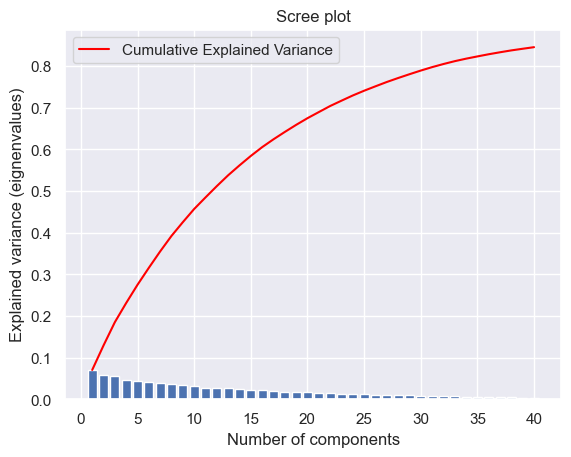

In [23]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

embed_dataset = pd.read_pickle('mediapipe_facenet_embeddings.pkl')
embedding_matrix = np.vstack(embed_dataset["embeddings"].values)
labels = embed_dataset["label"].values
image = embed_dataset["image"].values

pca = PCA(n_components=40)
reduced_embeddings = pca.fit_transform(embedding_matrix)
pca_df = pd.DataFrame(reduced_embeddings)
pca_df["label"] = labels
pca_df["image"] = image
 
# Scree Plot
import numpy as np
# Bar plot of explained_variance
plt.bar(
    range(1,len(pca.explained_variance_)+1),
    pca.explained_variance_
    )
 
plt.plot(
    range(1,len(pca.explained_variance_ )+1),
    np.cumsum(pca.explained_variance_),
    c='red',
    label='Cumulative Explained Variance')
 
plt.legend(loc='upper left')
plt.xlabel('Number of components')
plt.ylabel('Explained variance (eignenvalues)')
plt.title('Scree plot')
 
plt.show()

# NMDS

breaking at iteration 2 with stress 0.30043775753674395
breaking at iteration 2 with stress 0.3006237188972701
breaking at iteration 2 with stress 0.3032363806933788
breaking at iteration 2 with stress 0.30027603221751803
breaking at iteration 3 with stress 0.30414909446091365
breaking at iteration 2 with stress 0.3014855625236448
breaking at iteration 2 with stress 0.3003519516932627
breaking at iteration 2 with stress 0.29981019257646757
breaking at iteration 2 with stress 0.3002515856461347
breaking at iteration 2 with stress 0.29965309407096785


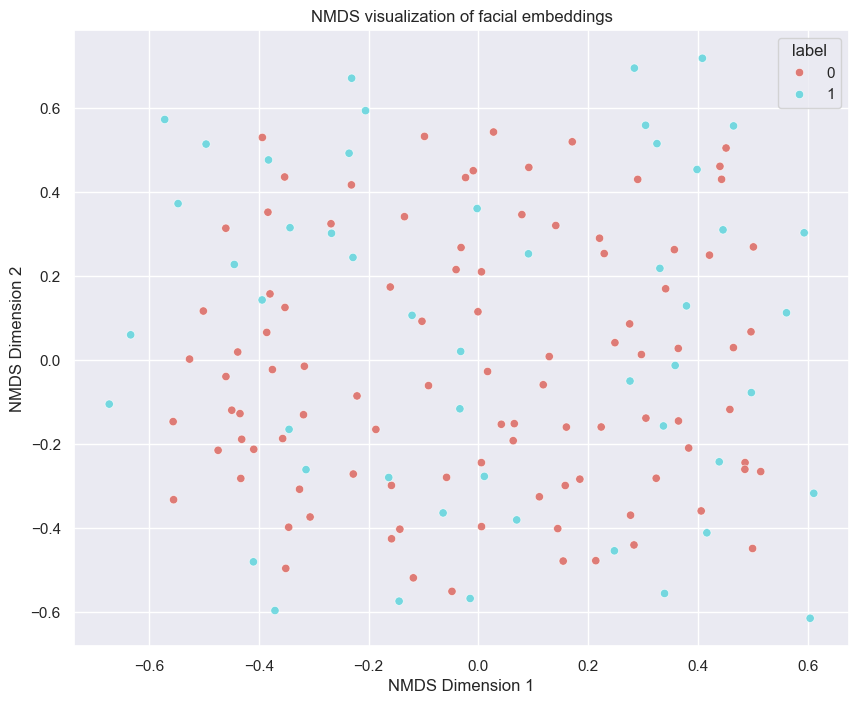

In [24]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns

# Load your embeddings
embed_dataset = pd.read_pickle('mediapipe_facenet_embeddings.pkl')  # or whatever your pickle file is named
embedding_matrix = np.vstack(embed_dataset["embeddings"].values)
labels = embed_dataset["label"].values
image = embed_dataset["image"].values

# Apply NMDS - you can try different n_components values
n_components = 2  # For 2D visualization
nmds = MDS(n_components=n_components, metric=False, random_state=42, 
           n_init=10, max_iter=300, verbose=1, eps=1e-6, 
           dissimilarity='euclidean')
reduced_embeddings = nmds.fit_transform(embedding_matrix)

# Create a DataFrame with the reduced dimensions
nmds_df = pd.DataFrame(reduced_embeddings)
nmds_df["label"] = labels
nmds_df["image"] = image

# Save the NMDS DataFrame
nmds_df.to_pickle(f"df_nmds_{n_components}")

# Visualize the results
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=0, y=1,
    hue="label",
    palette=sns.color_palette("hls", len(np.unique(labels))),
    data=nmds_df,
    legend="full",
    alpha=0.8
)
plt.title('NMDS visualization of facial embeddings')
plt.xlabel('NMDS Dimension 1')
plt.ylabel('NMDS Dimension 2')
plt.show()

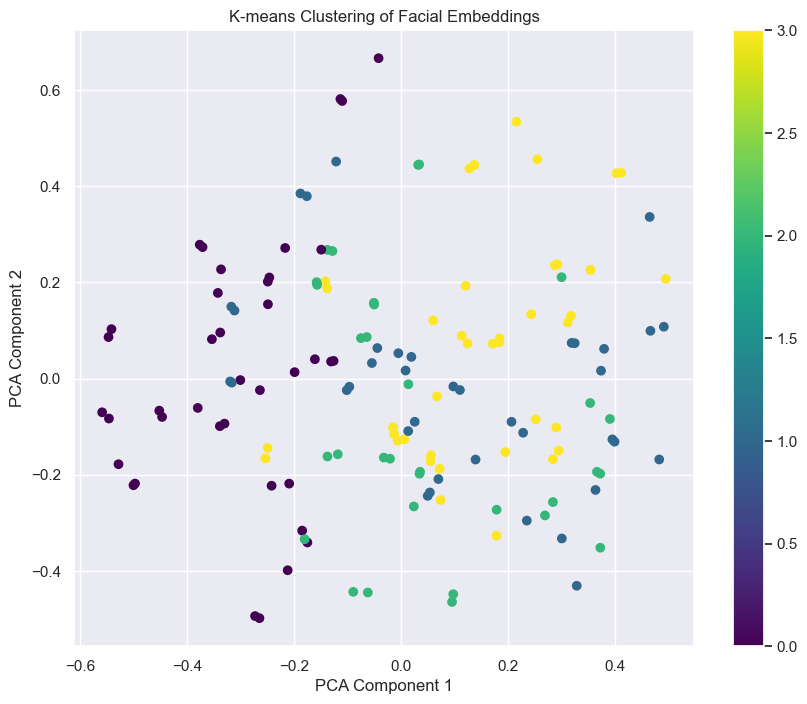

actual_label   0   1
cluster             
0             30   9
1             26  12
2             24   8
3             18  21


In [25]:
from sklearn.cluster import KMeans

# Try different numbers of clusters
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(embedding_matrix)

# Use PCA for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embedding_matrix)

# Plot clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], 
                      c=clusters, cmap='viridis')
plt.colorbar(scatter)
plt.title('K-means Clustering of Facial Embeddings')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Compare clusters with your actual labels
cluster_df = pd.DataFrame({
    'cluster': clusters,
    'actual_label': labels
})
print(pd.crosstab(cluster_df['cluster'], cluster_df['actual_label']))